In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import plotly.io
import numpy as np
from sklearn.cluster import KMeans

## Pipelining components of ML

In [2]:
# Load the myopia dataset
file_path = Path("Resources/myopia.csv")
df = pd.read_csv(file_path)
df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


Data Preparation Cheat Sheet
1. check datatypes (numeric cols may have non-numeric info that needs to be removed, data types may need to be changed) 
    df.dtypes

2. replace categorical with numeric values - consider replacing empty strings with NaN 
    https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/


    df['colname'].unique()
    df['colname'].replace(['uniquevalue1', 'uniquevalue2','uniquevalue3',''],
                        [1,2,3,0], inplace=True)

    OR
    
    dummies = pd.get_dummies(df.colname)
    merged = pd.concat([df,dummies].axis='columns')
    merged.drop('colname',axis='columns')

    OR (example from homework Mod20-Day1-Activity02)

    df['colname'].unique()
    colname_dict = {'uniquevalue1': 1, 'uniquevalue2': 2, 'uniquevalue3': 3}
    df2 = df.replace({'colname': colname_dict})
     note: not sure how this would handle a null

    OR (example from homework Mod20-Day1-Activity03)

    def changeChannel(channel):
        if channel == "uniquevalue1":
            return 1
        if channel == "uniquevalue2":
            return 2
        if channel == "uniquevalue3":
            return 2        
        else:
            return 0 
    df_shopping["Channel"] = df_shopping["Channel"].apply(changeChannel)

3. check for nas, nulls and remove if necessary  (na = NOT A NUMBER)  NOTE: df.isna() == df.isnull()  
    https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

    df.isna().sum()
    df.dropna() 

    NOTE: This does not detect empty strings.  To detect empty strings search for df['colname']==''
    https://stackoverflow.com/questions/27159189/find-empty-or-nan-entry-in-pandas-dataframe

4. check for duplicate values and remove if necessary
    https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

    df.duplicated().sum()
    df.drop_duplicates(keep='first')  note: keep = 'first' is default


5. drop unnecessary columns 
    https://www.w3schools.com/python/pandas/ref_df_drop.asp#:~:text=The%20drop()%20method%20removes

    df.drop(columns=['colname'])
    or
    df.drop('colname',axis = 1)
    df.drop('colname',axis = 'columns')

6. standardize dataset so larger numbers don't influence the outcome more

    Scale the data (example from homework Mod20-Day1-Activity03)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_shopping[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']])

        # A list of the columns from the original DataFrame
        df_shopping.columns

        # Create a DataFrame with the transformed data
        new_df_shopping = pd.DataFrame(scaled_data, columns=df_shopping.columns[1:])
        new_df_shopping['Channel'] = df_shopping['Channel']
        new_df_shopping.head()

In [3]:
# Features of the dataset
origcols = df.columns
origcols

Index(['AGE', 'SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR', 'READHR', 'COMPHR',
       'STUDYHR', 'TVHR', 'DIOPTERHR', 'MOMMY', 'DADMY', 'MYOPIC'],
      dtype='object')

In [4]:
# check datatypes
df.dtypes

AGE            int64
SPHEQ        float64
AL           float64
ACD          float64
LT           float64
VCD          float64
SPORTHR        int64
READHR         int64
COMPHR         int64
STUDYHR        int64
TVHR           int64
DIOPTERHR      int64
MOMMY          int64
DADMY          int64
MYOPIC         int64
dtype: object

In [5]:
# Count of rows with null values
df.isna().sum()

AGE          0
SPHEQ        0
AL           0
ACD          0
LT           0
VCD          0
SPORTHR      0
READHR       0
COMPHR       0
STUDYHR      0
TVHR         0
DIOPTERHR    0
MOMMY        0
DADMY        0
MYOPIC       0
dtype: int64

In [6]:
#set labels as myopic diagnosis for optional charting
labels = df['MYOPIC']

In [7]:
# check for duplicates
df.duplicated()
print(df[df.duplicated()])

Empty DataFrame
Columns: [AGE, SPHEQ, AL, ACD, LT, VCD, SPORTHR, READHR, COMPHR, STUDYHR, TVHR, DIOPTERHR, MOMMY, DADMY, MYOPIC]
Index: []


In [8]:
# scale dataset without mommy, dadmy, or myopic columns
scaler = StandardScaler()
dataScaled= scaler.fit_transform(df[['AGE', 'SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR', 'READHR', 'COMPHR',
       'STUDYHR', 'TVHR', 'DIOPTERHR']])


In [9]:
# Create a DataFrame with the transformed data and replace mommy and dadmy cols - leave myopic column out as it could bias the analysis
dfScaled = pd.DataFrame(dataScaled, columns=['AGE', 'SPHEQ', 'AL', 'ACD', 'LT', 'VCD', 'SPORTHR', 'READHR', 'COMPHR',
       'STUDYHR', 'TVHR', 'DIOPTERHR'])
dfScaled['MOMMY'] = df['MOMMY']
dfScaled['DADMY'] = df['DADMY']
dfScaled.head()  

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,-0.420219,-1.363917,-0.892861,0.483784,-0.281443,-1.019792,4.150661,1.697450,-0.689311,-0.672996,0.184058,0.498304,1,1
1,-0.420219,-0.308612,-0.171840,0.535910,-0.967997,-0.130763,-0.998898,-0.912062,-0.361875,-0.221409,-0.340932,-0.875088,1,1
2,-0.420219,0.604386,-0.009977,-0.506628,-0.177812,0.215809,0.257092,-0.912062,-0.034439,-0.672996,0.184058,-0.750234,0,0
3,-0.420219,-0.441325,-0.436703,1.230936,0.456927,-0.974587,0.759488,2.676017,-0.689311,-0.672996,-0.865922,0.685585,0,1
4,-1.823978,-0.166306,1.167204,0.422970,-0.566427,1.180178,0.257092,-0.912062,-0.689311,-0.672996,-0.865922,-1.374503,1,0


In [10]:
# get list of dfScaled columns
ldfScaledCols = dfScaled.columns
ldfScaledCols = ldfScaledCols.to_list()
ldfScaledCols

['AGE',
 'SPHEQ',
 'AL',
 'ACD',
 'LT',
 'VCD',
 'SPORTHR',
 'READHR',
 'COMPHR',
 'STUDYHR',
 'TVHR',
 'DIOPTERHR',
 'MOMMY',
 'DADMY']

In [11]:
# Saving cleaned data
file_path = Path("Resources/MyopiaCleanData.csv")
dfScaled.to_csv(file_path, index=False)


In [12]:
# apply dimensionality reduction using PCA with explained variance set to 90% (Mod20-Day01-Act06)
# Initialize PCA model
pca = PCA(n_components=0.9)

# Get principal components for the myopia data.
scaledPCA = pca.fit_transform(dfScaled)
len(scaledPCA[0])

9

In [13]:
# get info about scaledPCA
print(len(scaledPCA[0]))
print(type(scaledPCA))
scaledPCA

9
<class 'numpy.ndarray'>


array([[ 0.50906415,  1.24000202,  0.75679484, ..., -1.84627049,
         0.14216401, -1.35436002],
       [-0.65978105, -1.47965678, -0.44354627, ..., -0.43461239,
        -0.6270534 , -0.35441185],
       [-0.90514553, -0.81617699,  0.73669118, ...,  0.18729979,
         0.07524173, -0.17210097],
       ...,
       [-0.92260377, -2.23850564, -0.46541164, ...,  0.66932235,
        -0.12628489,  0.6176157 ],
       [-1.09590032,  0.37773304,  0.73323505, ..., -1.08971852,
        -0.83776331,  0.32957581],
       [-0.72208485, -0.64937276,  0.98204191, ..., -0.91635201,
         0.38841272, -0.86992522]])

In [14]:
# Transform PCA data to a Data Frame
dfscaledPCA = pd.DataFrame(scaledPCA)
dfscaledPCA.head()

,0,1,2,3,4,5,6,7,8
0,0.509064,1.240002,0.756795,-3.399057,-1.372825,-2.062353,-1.846270,0.142164,-1.354360
1,-0.659781,-1.479657,-0.443546,0.728013,-0.210619,0.132010,-0.434612,-0.627053,-0.354412
2,-0.905146,-0.816177,0.736691,-0.161225,0.903472,-0.048094,0.187300,0.075242,-0.172101
3,0.117579,1.143982,-0.978658,-1.216472,-2.095468,-1.900045,-0.315069,-0.541609,0.693329
4,-0.406560,-2.788647,0.560417,-0.462657,-0.278111,-0.882195,0.701336,0.528334,0.107169


In [15]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.23709653 0.17470773 0.09439418 0.08260749 0.07899141 0.07203043
 0.07101828 0.05837071 0.0488404 ]


0.9180571519113612

In [16]:
# reduce dataset dimensions with t-SNE using the PCA output (Mod20-Day02-Act04)
# Initialize t-SNE model (learning rate can be changed,larger numbers take more time)
tsne = TSNE(learning_rate=35)

# Reduce dimensions
tsne_features = tsne.fit_transform(dfscaledPCA)

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [17]:
 # get tsne_features shape
tsne_features.shape

(618, 2)

In [18]:
# get info about tsne_features
print(len(tsne_features[0]))
print(type(tsne_features))
tsne_features

2
<class 'numpy.ndarray'>


array([[-16.699198  , -16.28674   ],
       [ 14.761393  ,  11.197294  ],
       [  5.145194  ,   8.042224  ],
       ...,
       [  7.6309776 ,  17.191597  ],
       [  1.3621063 ,   3.7868273 ],
       [ 11.043449  ,  -0.03091066]], dtype=float32)

In [19]:
# Create a scatterplot of the t-SNE output.
# Prepare to plot the dataset

# The first column of transformed features
dfscaledPCA['x'] = tsne_features[:,0]

# The second column of transformed features
dfscaledPCA['y'] = tsne_features[:,1]

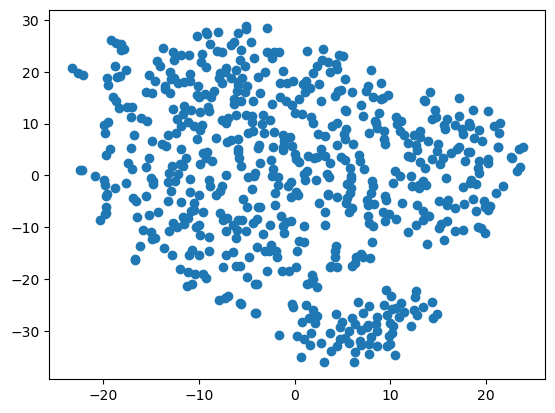

In [20]:
# Visualize the clusters
plt.scatter(dfscaledPCA['x'], dfscaledPCA['y'])
plt.show()

In [21]:
# check number of labels from df.myopic
labels.value_counts()

0    537
1     81
Name: MYOPIC, dtype: int64

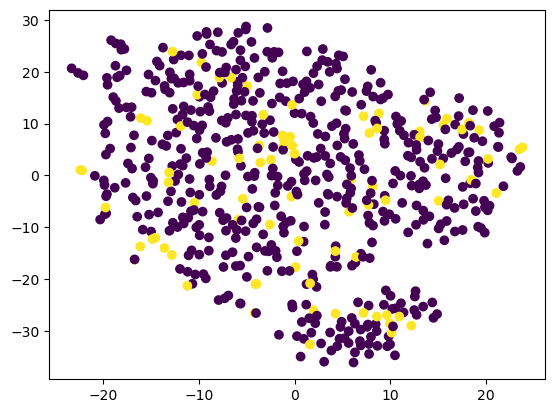

In [22]:
# Visualize the clusters with MYOPIC identification
plt.scatter(dfscaledPCA['x'], dfscaledPCA['y'],c=labels)
plt.savefig('Resources/t-SNE_learn35.png', transparent = False)
plt.show()

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


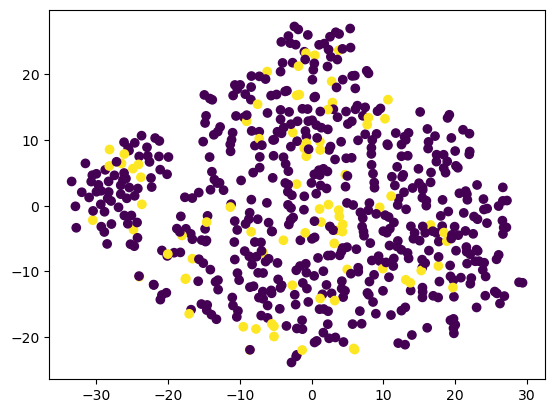

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


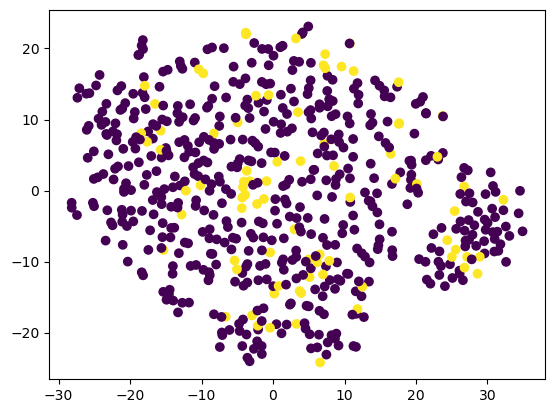

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


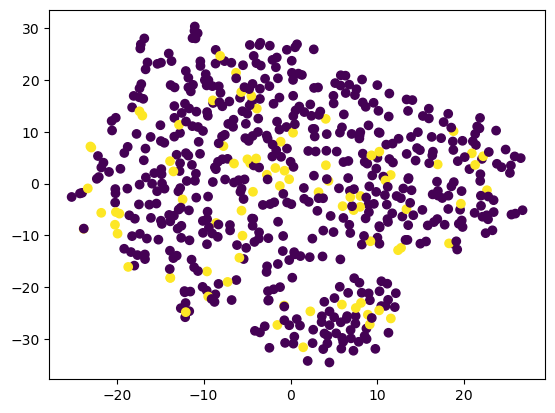

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


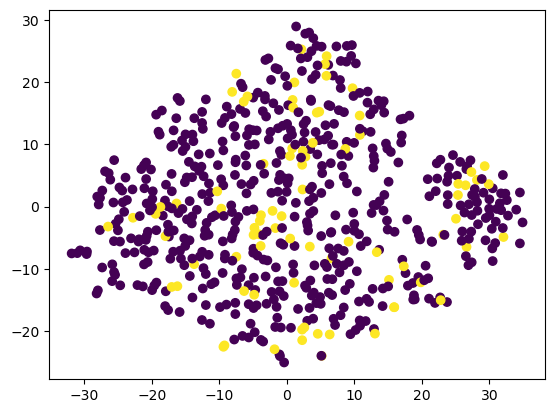

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


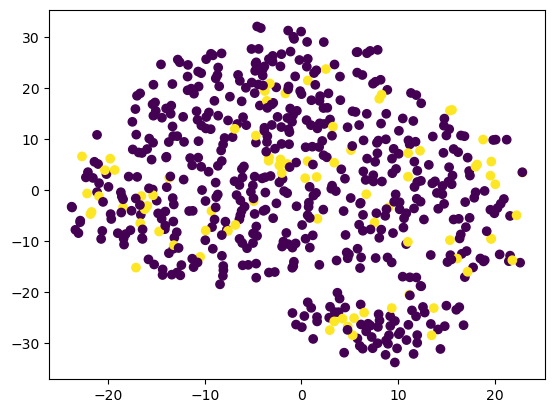

In [23]:
# Assess run to run variability by rerunning analyses 5x with learning rate = 35: reduce dataset dimensions with t-SNE using the PCA output (Mod20-Day02-Act04) LEARNING RATE 35, bubble = number times to rerun analysis, previous x and y removed prior to rerun (or they will affect analyses)
for bubble in range(0,5):
    dfscaledPCA = dfscaledPCA.drop(['x','y'], axis = 1)
    tsne = TSNE(learning_rate=35)
    tsne_features = tsne.fit_transform(dfscaledPCA)
    dfscaledPCA['x'] = tsne_features[:,0]
    dfscaledPCA['y'] = tsne_features[:,1]
    print(labels.value_counts())
    plt.scatter(dfscaledPCA['x'], dfscaledPCA['y'],c=labels)
    plt.savefig(f'Resources/t-SNE_learn35-{bubble}.png', transparent = False)
    plt.show()

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


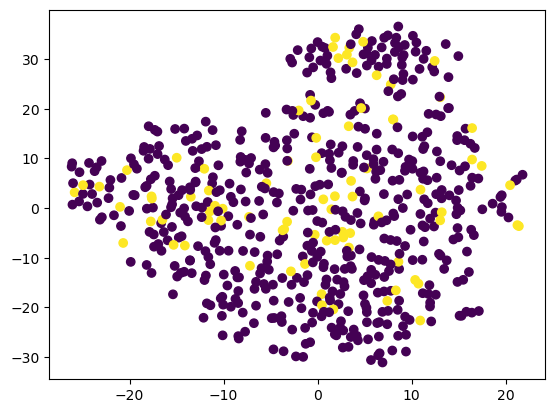

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


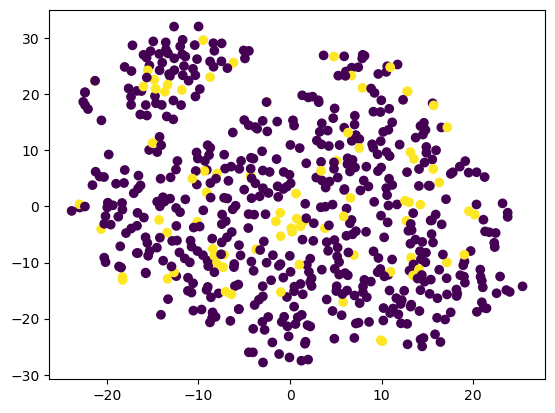

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


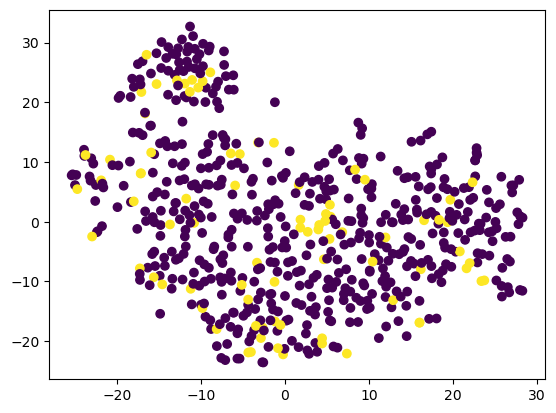

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


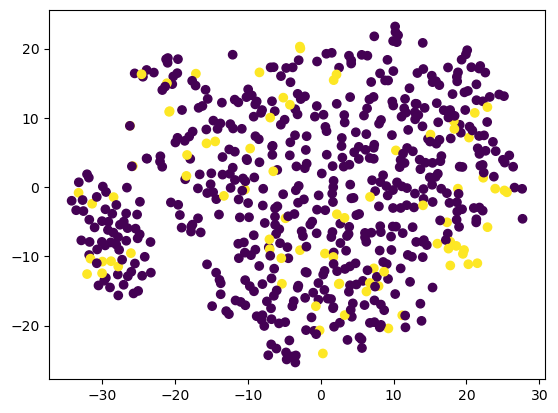

c:\Users\chris\anaconda3\envs\mlenv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


0    537
1     81
Name: MYOPIC, dtype: int64


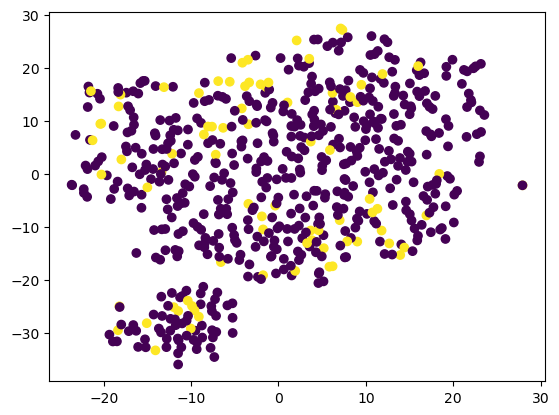

In [24]:
# Assess run to run variability by rerunning analyses 5x with learning rate = 80: reduce dataset dimensions with t-SNE using the PCA output (Mod20-Day02-Act04) LEARNING RATE 80, bubble = number times to rerun analysis, previous x and y removed prior to rerun (or they will affect analyses)
for bubble in range(0,5):
    dfscaledPCA = dfscaledPCA.drop(['x','y'], axis = 1)
    tsne = TSNE(learning_rate=80)
    tsne_features = tsne.fit_transform(dfscaledPCA)
    dfscaledPCA['x'] = tsne_features[:,0]
    dfscaledPCA['y'] = tsne_features[:,1]
    print(labels.value_counts())
    plt.scatter(dfscaledPCA['x'], dfscaledPCA['y'],c=labels)
    plt.savefig(f'Resources/t-SNE_learn80-{bubble}.png', transparent = False)
    plt.show()

There are two clusters in the scatter plot of the t-SNE output with the learning rate of either 35 or 80.
Dimensions were reduced from nine features (PCA output) to two.


Optional:  These clusters do not correspond with the actual clinical diagnosis (represented by yellow and purple on the chart) as represented in the "Myopic" column.  t-SNE is a dimension reduction tool to allow for visualization of multi-dimentional data in 2D or 3D. t-SNE is not a classification or regression tool.

In [25]:
# k-means: identify the best number of clusters using the elbow curve
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(dfScaled)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,7724.972492
1,2,6571.031691
2,3,5805.239805
3,4,5438.044811
4,5,5164.243308


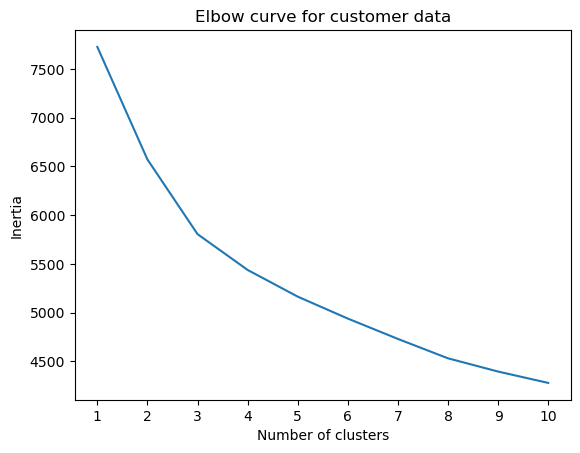

In [26]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [27]:
# function to find k clusters using k-means on data
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [28]:
# #run with K=3 (elbow)
# k3=get_clusters(3,dfScaled)
# k3.head()

In [29]:
# function to show k clusters using k-means on data
def show_clusters(inputdf):
    plt.scatter(inputdf[xvar], inputdf[yvar], c=inputdf['class'])
    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title(f'{kay} clusters')
    plt.show()

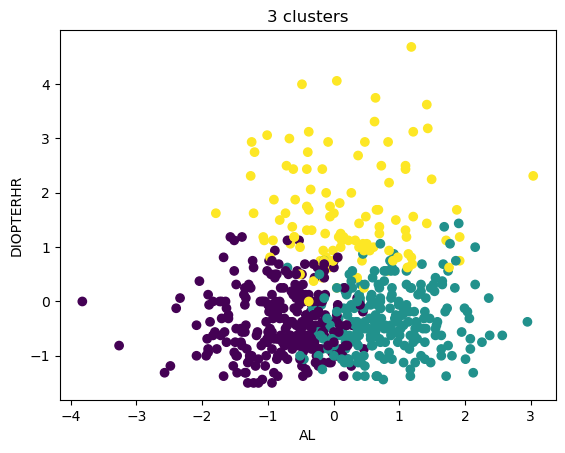

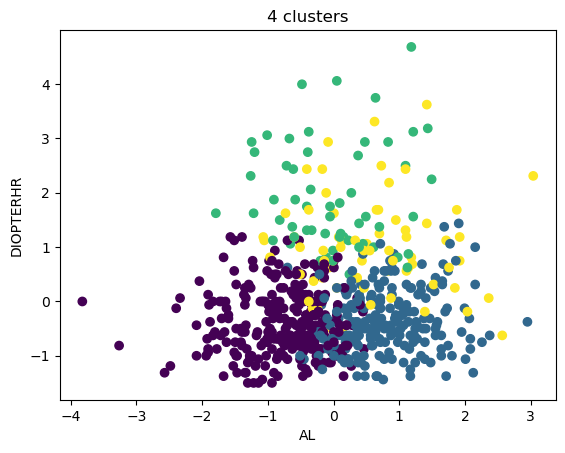

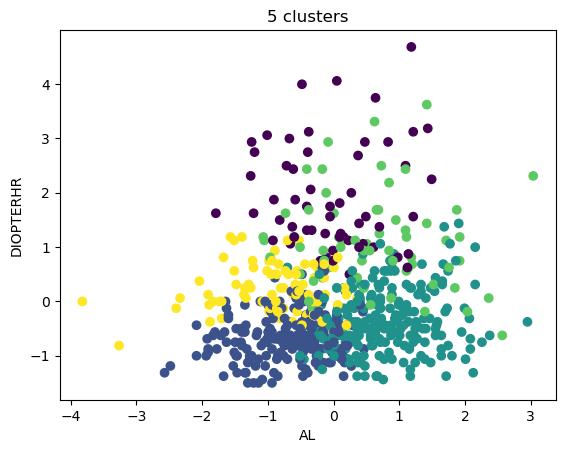

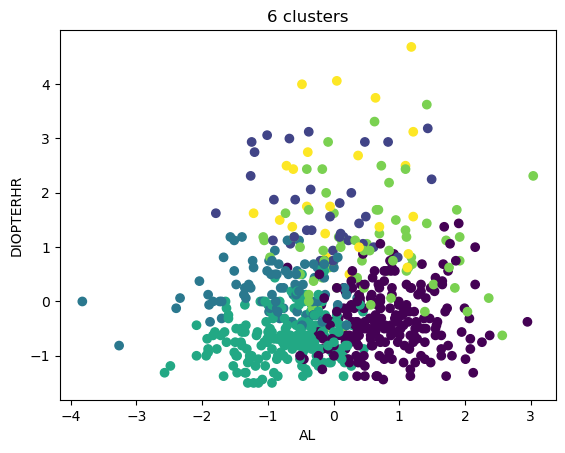

In [30]:
#run with K=3 get and show clusters
for kay in range(3,7):
    xvar = 'AL'
    yvar = 'DIOPTERHR'
    show_clusters(get_clusters(kay,dfScaled))

In [31]:
#check for added column 
dfScaled['class'].unique()

array([2, 0, 3, 5, 4, 1])

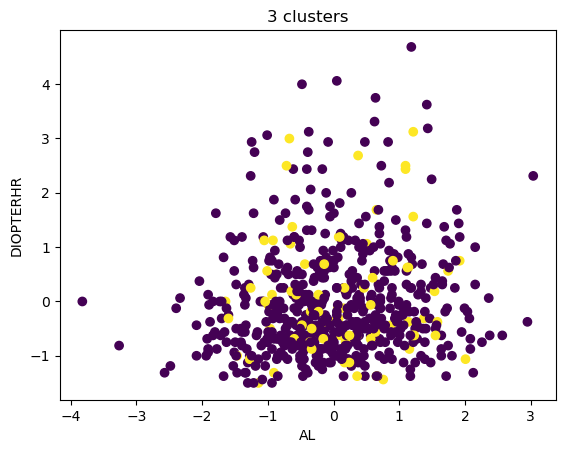

In [32]:
# CHECK AGAINST ACTUAL DIAGNOSIS
model = KMeans(n_clusters=3, random_state=0)
model.fit(dfScaled)
predictions = model.predict(dfScaled)
dfScaled["class"] = model.labels_

plt.scatter(dfScaled['AL'], dfScaled['DIOPTERHR'], c=labels)
plt.xlabel('AL')
plt.ylabel('DIOPTERHR')
plt.title('3 clusters')
plt.savefig('Resources/KClusters_3.png', transparent = False)
plt.show()


The elbow curve has a slight elbow at k = 3 clusters.
K-means run with k = 3 and random state = 0.  Clusters visualized using xvar = 'AL' and yvar = 'DIOPTERHR'
There is a visual distinction between the three clusters.

Optional:  These clusters do not correspond with the actual clinical diagnosis (represented by yellow and purple on the chart) as represented in the "Myopic" column.  K-means is a clustering tool (finds a grouping of data which maximizes between-clusters distances) rather than a classification tool.  


In [33]:
#  chart where K=3 for AL, ACD, and DIOPTERHR, based on CHECK ALL INPUT COMBOS AGAINST EACH OTHER (code below, outputs not saved due to size)
# reset df.class to 3 clusters
# model = KMeans(n_clusters=3, random_state=0)
# model.fit(dfScaled)
# predictions = model.predict(dfScaled)
# dfScaled["class"] = model.labels_

# plt.scatter(dfScaled['AL'], dfScaled['DIOPTERHR'], c=dfScaled['class'])
# plt.xlabel('AL')
# plt.ylabel('DIOPTERHR')
# plt.title('3 clusters')
# plt.savefig('Resources/KClusters_3.png', transparent = False)
# plt.show()


In [34]:
#try 3d plot  Mod20-Day01-Act07
# import plotly.express as px
# fig3 = px.scatter_3d(
#     dfScaled,
#     x="DIOPTERHR",
#     y="AL",
#     z="VCD",
#     color="class",
#     symbol="class",
#     width=800,
# )
# fig3.update_layout(legend=dict(x=0, y=1))
# fig3.show()

CHECK ALL INPUT COMBOS AGAINST EACH OTHER - 

In [35]:
# #function to use in every option against every option
# def show_clusters2Diagnosis(inputdf):
#     plt.scatter(inputdf[xvar], inputdf[yvar], c=labels)
#     plt.xlabel(xvar)
#     plt.ylabel(yvar)
#     plt.title(f'{kay} clusters')
#     plt.show()

In [36]:
# #every option against every option
# for kay in range(3,7):
#     for xvar in ldfScaledCols:
#         for yvar in ldfScaledCols:
#             show_clusters2Diagnosis(get_clusters(kay,dfScaled))

In [37]:
# #every option against every option
# for kay in range(3,7):
#     for xvar in ldfScaledCols:
#         for yvar in ldfScaledCols:
#             show_clusters(get_clusters(kay,dfScaled))